### 3-Layer Feed-Forward Neural Network

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Load the datasets (Dermatology / Pendigits)
def load_data(data_path):
    with open(data_path, "r") as file:
        data = []
        for line in file.readlines():
            if(line.find('?') == -1):
                _data = line.rstrip().split(',')
                # create a float array for computational purposes
                _data = [float(x) for x in _data]
                data.append(_data)
    return np.array(data)

In [3]:
# Activation functions and their gradients
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0)

def tanh(x):
    return np.tanh(x)

def gradient_sigmoid(x):
    return (x * (1 - x))

def gradient_relu(x):
    return (1 * (x > 0))

def gradient_tanh(x):
    return (1 - np.power(x, 2))

def softmax(x):
    exp_scores = np.exp(x)
    _probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return _probs

In [4]:
# for 3-layer neural network with ...
# Loss Function: Cross Entropy Loss
def compute_cross_entropy_loss(probs, y):
    n_samples = y.shape[0]
    log_probs = -1 * np.log(probs[range(n_samples), y])
    data_loss = 1./n_samples * np.sum(log_probs)
    return data_loss

In [5]:
# Build the model
def train_model(model, Xt, Yt, params, act_func, gradient):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # gather the params
    n_samples = params["n_samples"]
    learning_rate = params["l_rate"]
    n_epochs = params["epochs"]
    Yi = Yt-1

    for i in range(0, n_epochs):
        # perform a forward pass through the NN
        z1 = Xt.dot(W1) + b1
        a1 = act_func(z1)
        z2 = a1.dot(W2) + b2
        probs = softmax(z2)

        # backpropagation
        delta3 = np.array(probs)
        delta3[range(n_samples), Yi] -= 1
        delta2 = delta3.dot(W2.T) * gradient(a1)
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        dW1 = np.dot(Xt.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Updating parameters (Gradient Descent)
        W1 += -learning_rate * dW1
        b1 += -learning_rate * db1
        W2 += -learning_rate * dW2
        b2 += -learning_rate * db2

        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        #if i%500 == 0 or i+1 == n_epochs:
        #    data_loss = compute_cross_entropy_loss(probs, Yi)
        #    print(i, data_loss)

    return model

In [6]:
# Prediction accuracies
def predict(model, X, act_func):
    
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation
    z1 = X.dot(W1) + b1
    a1 = act_func(z1)
    z2 = a1.dot(W2) + b2
    probs = softmax(z2)
    predictions = np.argmax(probs, axis=1)
    return predictions+1

In [7]:
#Plot Accuracies
def plot_data(data_str, l_activations, l_hidden_nodes, d_accuracies):
    
    # Set the figure size
    matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
    plt.title(data_str)
    plt.xlabel('Number of Hidden Nodes')
    plt.ylabel('K-fold Prediction Accuracies')

    for func_str in l_activations:
        plt.plot(l_hidden_nodes,
                 d_accuracies[func_str],
                 label = func_str)

    plt.legend(loc=4)
    plt.show()

In [8]:
# creating a 3 layer Neural Network
def create_network(n_hidden_nodes,
                   activation,
                   gradient,
                   training_params,
                   train_data_path):

    # loading training dataset
    dataset = load_data(train_data_path)
    X = dataset[:,:-1]
    Y = dataset[:,-1]
    Y = Y.astype(int)

    n_input_nodes = X.shape[1]
    n_output_nodes = len(np.unique(Y))

    # Initialize the weights and biases to random values.
    # We need to learn these.
    model = {}
    #print("Creating Model for Hidden Nodes = {}\n".format(n_hidden_nodes))
    #print(model)
    np.random.seed(0)
    W1 = np.random.randn(n_input_nodes, n_hidden_nodes) / np.sqrt(n_input_nodes)
    b1 = np.zeros((1, n_hidden_nodes))
    W2 = np.random.randn(n_hidden_nodes, n_output_nodes) / np.sqrt(n_hidden_nodes)
    b2 = np.zeros((1, n_output_nodes))
    # Assign new parameters to the model
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    # dividing the dataset for k-fold cross validation
    k = 5
    total_samples = dataset.shape[0]
    chunk_size = int(total_samples/k)
    k_fold_accuracy = 0
    for i in range(k):
        k_fold_test_data  = dataset[i*chunk_size : (i+1)*chunk_size]
        k_fold_train_data = np.vstack((dataset[0 : i*chunk_size],
                                       dataset[(i+1)*chunk_size : ]))
        # Training samples
        X_train = k_fold_train_data[:,:-1]
        Y_train = k_fold_train_data[:,-1]
        Y_train = Y_train.astype(int)

        # Validation / Testing samples 
        X_test = k_fold_test_data[:,:-1]
        Y_test = k_fold_test_data[:,-1]
        Y_test = Y_test.astype(int)

        # Add no of samples to training params
        training_params["n_samples"] = X_train.shape[0]

        # train the Neural Network model
        model = train_model(model,
                            X_train,
                            Y_train,
                            training_params,
                            activation,
                            gradient)
        Yp = predict(model,
                     X_test,
                     activation)
        k_fold_accuracy += 100 * np.mean((Yp == Y_test))
    
    # mean accuracy after k-fold cross validation
    mean_accuracy = (k_fold_accuracy/k)

    return model, mean_accuracy


In [9]:
# GLOBAL PARAMETERS
DERMATOLOGY_DATA_PATH = "./datasets/dermatology.data"
PENDIGITS_TRAIN_DATA_PATH = "./datasets/pendigits.tra"
PENDIGITS_TEST_DATA_PATH = "./datasets/pendigits.tes"

l_activations = ["ReLU", "Tanh", "Sigmoid"]
l_hidden_nodes = [1,5,10,20,30,40,50,60,70,80,90,100]

# model training parameters

training_params = {
    "l_rate": 1e-5,
    "epochs": 2000
}

# A dictionary of activation functions
d_activation = {
    "ReLU": relu,
    "Tanh": tanh,
    "Sigmoid": sigmoid
}

# A dictionary of gradient functions
# for the corresponding activation functions
d_gradient = {
    "ReLU": gradient_relu,
    "Tanh": gradient_tanh,
    "Sigmoid": gradient_sigmoid
}


Activation function : "ReLU"

Learning Rate: 1e-05
No Of Epochs:  2000

No of Hidden Nodes: 1 ==> 5-fold Accuracy: 30.985915492957748
No of Hidden Nodes: 5 ==> 5-fold Accuracy: 92.67605633802816
No of Hidden Nodes: 10 ==> 5-fold Accuracy: 94.92957746478874
No of Hidden Nodes: 20 ==> 5-fold Accuracy: 96.3380281690141
No of Hidden Nodes: 30 ==> 5-fold Accuracy: 97.46478873239437
No of Hidden Nodes: 40 ==> 5-fold Accuracy: 97.18309859154928
No of Hidden Nodes: 50 ==> 5-fold Accuracy: 96.61971830985915
No of Hidden Nodes: 60 ==> 5-fold Accuracy: 97.18309859154928
No of Hidden Nodes: 70 ==> 5-fold Accuracy: 97.1830985915493
No of Hidden Nodes: 80 ==> 5-fold Accuracy: 96.61971830985915
No of Hidden Nodes: 90 ==> 5-fold Accuracy: 98.02816901408451
No of Hidden Nodes: 100 ==> 5-fold Accuracy: 98.02816901408451

Activation function : "Tanh"

Learning Rate: 1e-05
No Of Epochs:  2000

No of Hidden Nodes: 1 ==> 5-fold Accuracy: 50.70422535211268
No of Hidden Nodes: 5 ==> 5-fold Accuracy: 41.12676

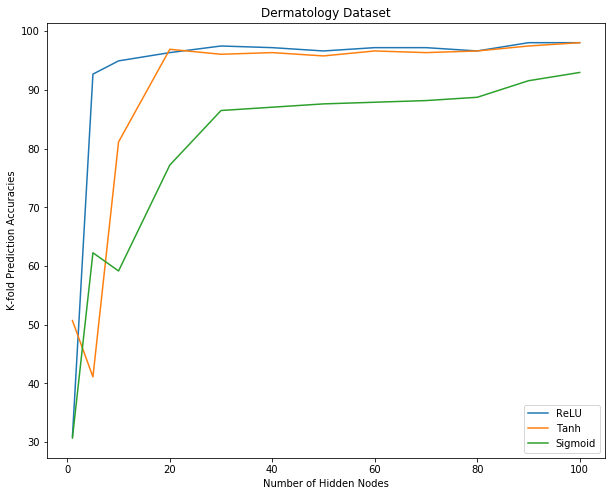

In [10]:
#######################
# DERMATOLOGY DATASET #
#######################

# lists to be filled
d_l_accuracies = {}

# Running for Dermatology dataset
for func_str in l_activations:
    print("\n================================")
    print("Activation function : \"{}\"".format(func_str))
    print("================================")
    print("\nLearning Rate: {}\nNo Of Epochs:  {}\n".format(training_params["l_rate"],
                                                           training_params["epochs"]))
    l_accuracies = []
    for n_hidden_nodes in l_hidden_nodes:
        model, mean_accuracy = create_network(n_hidden_nodes,
                                              d_activation[func_str],
                                              d_gradient[func_str],
                                              training_params,
                                              DERMATOLOGY_DATA_PATH)
        l_accuracies.append(mean_accuracy)
        print("No of Hidden Nodes: {} ==> 5-fold Accuracy: {}".format(n_hidden_nodes,
                                                                      mean_accuracy))
    d_l_accuracies[func_str] = list(l_accuracies)

# Plot the accuracies for all the activation functions
# for different hidden nodes count
plot_data("Dermatology Dataset", l_activations, l_hidden_nodes, d_l_accuracies)


Activation function : "ReLU"

Learning Rate: 1e-06
No Of Epochs:  2000

No of Hidden Nodes: 1 ==> 5-fold Accuracy: 9.946595460614152
No of Hidden Nodes: 5 ==> 5-fold Accuracy: 9.946595460614152
No of Hidden Nodes: 10 ==> 5-fold Accuracy: 84.0720961281709
No of Hidden Nodes: 20 ==> 5-fold Accuracy: 88.27770360480642
No of Hidden Nodes: 30 ==> 5-fold Accuracy: 88.73164218958611
No of Hidden Nodes: 40 ==> 5-fold Accuracy: 88.7316421895861
No of Hidden Nodes: 50 ==> 5-fold Accuracy: 88.90520694259013
No of Hidden Nodes: 60 ==> 5-fold Accuracy: 88.95861148197596
No of Hidden Nodes: 70 ==> 5-fold Accuracy: 88.91855807743659
No of Hidden Nodes: 80 ==> 5-fold Accuracy: 88.99866488651536
No of Hidden Nodes: 90 ==> 5-fold Accuracy: 89.01201602136182
No of Hidden Nodes: 100 ==> 5-fold Accuracy: 89.0520694259012

Model Chosen with hidden Nodes: 100
Accuracy over test data for this model is: 87.07833047455689

Activation function : "Tanh"

Learning Rate: 1e-05
No Of Epochs:  2000

No of Hidden Nod

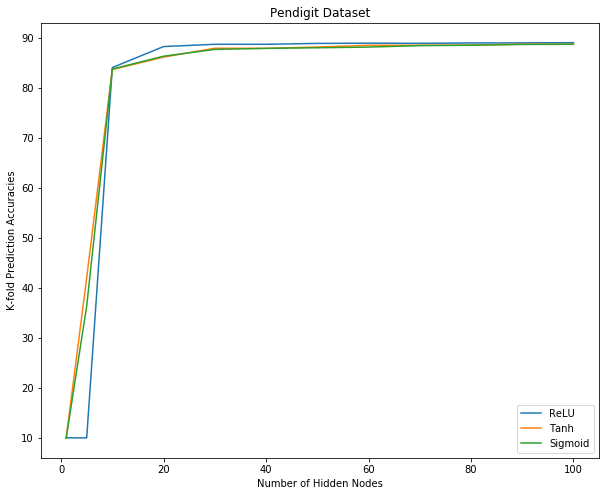

In [11]:
####################
# PENDIGIT DATASET #
####################

# lists to be filled
d_l_accuracies = {}

# Running for Pendigit dataset
for func_str in l_activations:
    # changing the learning rate for "ReLU"
    if func_str == "ReLU":
        training_params["l_rate"] = 1e-6
    else:
        training_params["l_rate"] = 1e-5

    print("\n================================")
    print("Activation function : \"{}\"".format(func_str))
    print("================================")
    print("\nLearning Rate: {}\nNo Of Epochs:  {}\n".format(training_params["l_rate"],
                                                            training_params["epochs"]))
    l_accuracies = []
    l_trained_models = []
    for n_hidden_nodes in l_hidden_nodes:
        t_model = {}
        t_model, mean_accuracy = create_network(n_hidden_nodes,
                                                d_activation[func_str],
                                                d_gradient[func_str],
                                                training_params,
                                                PENDIGITS_TRAIN_DATA_PATH)
        l_accuracies.append(mean_accuracy)
        l_trained_models.append(t_model)
        print("No of Hidden Nodes: {} ==> 5-fold Accuracy: {}".format(n_hidden_nodes,
                                                                      mean_accuracy))
    d_l_accuracies[func_str] = list(l_accuracies)

    # fetch the best model
    _accuracy = np.max(l_accuracies)
    _hnodes = l_hidden_nodes[np.argmax(l_accuracies)]
    _model = l_trained_models[np.argmax(l_accuracies)]
    
    # Load the test data set
    test_dataset = load_data(PENDIGITS_TEST_DATA_PATH)
    
    # Features and Labels
    test_X = test_dataset[:,:-1]
    test_Y = test_dataset[:,-1]
    test_Y = test_Y.astype(int)

    test_Yp = predict(_model,
                      test_X,
                      d_activation[func_str])
    test_accuracy = 100 * np.mean((test_Yp == test_Y))
    print("\nModel Chosen with hidden Nodes: {}".format(_hnodes))
    print("Accuracy over test data for this model is: {}".format(test_accuracy))

# Plot the accuracies for all the activation functions
# for different hidden nodes count
plot_data("Pendigit Dataset", l_activations, l_hidden_nodes, d_l_accuracies)